<a href="https://colab.research.google.com/github/dbejarano31/Master-Thesis-Information-Management/blob/main/finBERT_HF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FinBERT

In this notebook we try the pre-trained FinBERT model by [Araci, 2019](https://arxiv.org/abs/1908.10063). FinBERT is pre-trained on the TRC2 news dataset from Reuters and the Financial PhraseBank dataset. We download the pre-trained model from the HuggingFace transformers library, [see here](https://huggingface.co/ProsusAI/finbert).
<br></br>
To access the dataset, [see here](https://drive.google.com/file/d/1o1BMTTU9YNPATL8x93l0N-h6sTZxLyDo/view?usp=sharing). 

## Imports

In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install ray[tune]

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-r00jrm_j
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-r00jrm_j
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.6.0.dev0-cp37-none-any.whl size=2168830 sha256=b29c9746292edf72e3779a7721388866fedbee1fe692e815bb4f7af9ae6d1cbe
  Stored in directory: /tmp/pip-ephem-wheel-cache-d6hxff59/wheels/70/d3/52/b3fa4f8b8ef04167ac62e5bb2accb62ae764db2a378247490e
Successfully built transformers


In [ ]:
#!pip install transformers
from typing import TYPE_CHECKING, Any, Callable, Dict, List, Optional, Tuple, Union
import pandas as pd
import numpy as np
import math
import time

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('stopwords')
nltk.download('punkt')

import matplotlib.pyplot as plt
import seaborn as sns

import os

from transformers.utils import *
from transformers.data.data_collator import DataCollator, DataCollatorWithPadding, default_data_collator
from transformers.file_utils import (
    WEIGHTS_NAME,
    is_apex_available,
    is_datasets_available,
    is_in_notebook,
    is_sagemaker_dp_enabled,
    is_sagemaker_mp_enabled,
    is_torch_tpu_available,
    is_training_run_on_sagemaker,
)
from transformers.modeling_utils import PreTrainedModel, unwrap_model
from transformers.optimization import Adafactor, AdamW, get_scheduler
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.trainer_callback import (
    CallbackHandler,
    DefaultFlowCallback,
    PrinterCallback,
    ProgressCallback,
    TrainerCallback,
    TrainerControl,
    TrainerState,
)
from transformers.trainer_utils import (
    PREFIX_CHECKPOINT_DIR,
    BestRun,
    EvalPrediction,
    HPSearchBackend,
    PredictionOutput,
    ShardedDDPOption,
    TrainerMemoryTracker,
    TrainOutput,
    default_compute_objective,
    default_hp_space,
    denumpify_detensorize,
    get_last_checkpoint,
    set_seed,
    speed_metrics,
)
from transformers.training_args import ParallelMode, TrainingArguments
from transformers.utils import logging
from transformers.utils.modeling_auto_mapping import MODEL_FOR_QUESTION_ANSWERING_MAPPING_NAMES 
import torch
import tensorflow as tf
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
import tensorflow_hub as hub

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split



from torch.utils.data.dataset import Dataset



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Connecting to cloud hardware

Edit > Notebook Settings > Hardware accelerator

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('There are %d GPU(s) available' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
  print('No GPU available, using CPU')
  device = torch.device("cpu")

There are 1 GPU(s) available
We will use the GPU: Tesla T4


## Importing data

In [ ]:
df = pd.read_csv('/content/final_consolidated_data')
df.head()

,Unnamed: 0,CIK Code,Filing,Date Filed,Ticker,CompanyName,PrevAvgPriceChange,PostAvgPriceChange,Label
0,0,1680378,Investing in ourshares of common stock involve...,2021-03-18,SNES,"SenesTech, Inc.",0.001328,-0.003177,decrease
1,1,1222719,Investing in any of our securities involves ri...,2021-01-31,CHY,CALAMOS CONVERTIBLE & HIGH INCOME FUND,0.004126,0.006552,neutral
2,2,1364954,An investment in our securities involves a hig...,2021-04-03,CHGG,"CHEGG, INC",0.065078,0.011987,neutral
3,3,1674930,Investing in our common stock involves risk. B...,2020-08-12,FLGT,"Fulgent Genetics, Inc.",0.412805,0.058477,neutral
4,4,1409375,Investing in our common stock involves a high ...,2021-03-10,OESX,"ORION ENERGY SYSTEMS, INC.",-0.046603,-0.002521,neutral


In [ ]:
df.drop(columns = 'Unnamed: 0', inplace = True)
df.dropna(axis = 0, how = 'any', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1350 entries, 0 to 1349
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CIK Code            1350 non-null   int64  
 1   Filing              1350 non-null   object 
 2   Date Filed          1350 non-null   object 
 3   Ticker              1350 non-null   object 
 4   CompanyName         1350 non-null   object 
 5   PrevAvgPriceChange  1350 non-null   float64
 6   PostAvgPriceChange  1350 non-null   float64
 7   Label               1350 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 94.9+ KB


## Configuration of parameters

In [ ]:
finbert = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert', cache_dir = None, num_labels = 3)
config = finbert.config

In [ ]:
config.hidden_dropout_prob = 0.5
config.layer_norm_eps = 0.01
max_seq_length = config.max_position_embeddings = 200
config.id2label[0] = 'decrease'
config.id2label[1] = 'neutral'
config.id2label[2] = 'increase'
config.label2id['decrease'] = 0
config.label2id['neutral'] = 1
config.label2id['increase'] = 2
del config.label2id['negative']
del config.label2id['positive']
config

BertConfig {
  "_name_or_path": "ProsusAI/finbert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.5,
  "hidden_size": 768,
  "id2label": {
    "0": "decrease",
    "1": "neutral",
    "2": "increase"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "decrease": 0,
    "increase": 2,
    "neutral": 1
  },
  "layer_norm_eps": 0.01,
  "max_position_embeddings": 200,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')

In [ ]:
batch_size = 32
epochs = 5
lr = 1e-5

## Data pre-processing

In [ ]:
# Stop word removal
def remove_stopwords(text):
  filtered = []
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(text)
  for w in word_tokens:
    if w not in stop_words:
      filtered.append(w)
  filtered_doc = ' '.join(str(i) for i in filtered)
  return filtered_doc

In [ ]:
df['Filing'] = df['Filing'].apply(lambda x: remove_stopwords(x))

Here we are going to perform the train/validation/test split of our data. We also do one-hot encoding of our labels. 

In [ ]:
x = df.Filing.values
y = df.Label.values
labs = []

for i in y:
  if i == 'decrease':
    labs.append(0)
  elif i == 'neutral':
    labs.append(1)
  else:
    labs.append(2)
labs = np.array(labs)
x_train, x_test, y_train, y_test = train_test_split(x,labs, test_size = 0.2, random_state = 42)
train_texts, val_texts, train_labels, val_labels = train_test_split(x_train, y_train, test_size =0.2)

Below is where the tokenization magic happens. We use the arguments `return_overflowing_tokens` and `return_offsets_mapping` in order to segment long filings into windows of 150 tokens, and map the "sub-filings" to the label of the "parent" filing. The argument `stride` is used to impose some token overlap into the sub-filings. We use this to minimize the contextual loss that comes from truncation. 


In [ ]:
train_encodings = tokenizer(list(train_texts),
                            truncation = True,
                            padding = True,
                            return_overflowing_tokens = True,
                            return_offsets_mapping = True,
                            stride = 100,
                            max_length = max_seq_length,
                            return_tensors = 'pt')

val_encodings = tokenizer(list(val_texts),
                          truncation = True,
                          padding = True,
                          return_overflowing_tokens = True,
                          return_offsets_mapping = True,
                          stride = 100,
                          max_length = max_seq_length,
                          return_tensors = 'pt')

test_encodings = tokenizer(list(x_test),
                           truncation = True,
                           padding = True,
                           return_overflowing_tokens = True,
                           return_offsets_mapping = True,
                           stride = 100,
                           max_length = max_seq_length,
                           return_tensors = 'pt')

Here we look at the `overflow_to_sample_mapping` in order to match the "sub-filings" to the labels of the parent filing. 

In [ ]:
train_sub_labs = []
val_sub_labs = []
test_sub_labs = []

for idx, lab in enumerate(train_labels):
  for i in train_encodings['overflow_to_sample_mapping']:
    if i == idx:
      train_sub_labs.append(lab)

for idx, lab in enumerate(val_labels):
  for i in val_encodings['overflow_to_sample_mapping']:
    if i == idx:
      val_sub_labs.append(lab)

for idx, lab in enumerate(y_test):
  for i in test_encodings['overflow_to_sample_mapping']:
    if i == idx:
      test_sub_labs.append(lab)

train_sub_labs = np.array(train_sub_labs)
val_sub_labs = np.array(val_sub_labs)
test_sub_labs = np.array(test_sub_labs)

To create the windows of the long filings, the tokenizer returned some items that are not recognized by BERT models for fine-tuning. We need to get rid of those. 

In [ ]:
print('Model requirements: {}'.format(tokenizer.model_input_names))
print('='*90)
print('Current inputs: {}'.format(train_encodings.keys))

Model requirements: ['input_ids', 'token_type_ids', 'attention_mask']
Current inputs: <bound method BatchEncoding.keys of {'input_ids': tensor([[  101,  1028,  8875,  ...,     0,     0,     0],
        [  101,  6614,  5714,  ..., 14728,  6970,   102],
        [  101,  3737,  3820,  ...,     0,     0,     0],
        ...,
        [  101,  3006,  3037,  ...,  2326, 14422,   102],
        [  101,  2094, 21693,  ...,     0,     0,     0],
        [  101,  2006,  2258,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'offset_mapping': tensor([[

In [ ]:
train_encodings.pop('overflow_to_sample_mapping')
train_encodings.pop('offset_mapping')
test_encodings.pop('overflow_to_sample_mapping')
test_encodings.pop('offset_mapping')
val_encodings.pop('overflow_to_sample_mapping')
val_encodings.pop('offset_mapping')
train_encodings.keys

<bound method BatchEncoding.keys of {'input_ids': tensor([[  101,  1028,  8875,  ...,     0,     0,     0],
        [  101,  1028,  8875,  ...,     0,     0,     0],
        [  101,  1028,  8875,  ...,     0,     0,     0],
        ...,
        [  101,  2961,  1010,  ...,  8910, 13266,   102],
        [  101, 13421,  3382,  ...,  4989, 11075,   102],
        [  101,  8910, 13266,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])}>

In [ ]:
class SEC_Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = SEC_Dataset(train_encodings, train_sub_labs)
val_dataset = SEC_Dataset(val_encodings, val_sub_labs)
test_dataset = SEC_Dataset(test_encodings, test_sub_labs)

## Performance metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

def compute_metrics(eval_pred):
  labels = eval_pred.label_ids
  preds = eval_pred.predictions.argmax(-1)
  lab_names = [0,1,2]
  
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average ='weighted')
  acc = accuracy_score(labels, preds)
  print(precision_recall_fscore_support(labels, preds, average = None, labels = lab_names))


  dic = {
      'Accuracy': acc,
      'F1': f1,
      'Precision': precision,
      'Recall': recall
  }
  return dic

## Training

In [ ]:
class MyTrainer(Trainer):
  def __init__(self, model,
        args = None,
        data_collator = None,
        train_dataset = None,
        eval_dataset = None,
        tokenizer = None,
        model_init = None,
        compute_metrics = None,
        callbacks = None,
        optimizers = (None,None)
    ):

    super().__init__(model, args, data_collator, train_dataset, eval_dataset, tokenizer, model_init,
                  compute_metrics, callbacks, optimizers) 
    
  def evaluate(
        self,
        train_dataset = None,
        eval_dataset: Optional[Dataset] = None,
        ignore_keys: Optional[List[str]] = None,
        metric_key_prefix: str = "eval",
    ) -> Dict[str, float]:
        
        # memory metrics - must set up as early as possible
        self._memory_tracker.start()

        if eval_dataset is not None and not isinstance(eval_dataset, collections.abc.Sized):
            raise ValueError("eval_dataset must implement __len__")

        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader(eval_dataset)
        start_time = time.time()

        train_output = self.prediction_loop(
            train_dataloader,
            description = 'Training',
            prediction_loss_only = True if self.compute_metrics is None else None,
            ignore_keys = ignore_keys,
            metric_key_prefix = 'train',
            )


        eval_output = self.prediction_loop(
            eval_dataloader,
            description="Evaluation",
            # No point gathering the predictions if there are no metrics, otherwise we defer to
            # self.args.prediction_loss_only
            prediction_loss_only=True if self.compute_metrics is None else None,
            ignore_keys=ignore_keys,
            metric_key_prefix=metric_key_prefix,
        )
        train_n_samples = len(self.train_dataset)
        train_output.metrics.update(speed_metrics('train', start_time, train_n_samples))
        self.log(train_output.metrics)

        eval_n_samples = len(eval_dataset if eval_dataset is not None else self.eval_dataset)
        eval_output.metrics.update(speed_metrics(metric_key_prefix, start_time, eval_n_samples))
        self.log(eval_output.metrics)

        if self.args.tpu_metrics_debug or self.args.debug:
            # tpu-comment: Logging debug metrics for PyTorch/XLA (compile, execute times, ops, etc.)
            xm.master_print(met.metrics_report())
        
        train_output.metrics['eval_loss'] = 'No log'
        self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, eval_output.metrics)
        self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, train_output.metrics)

        self._memory_tracker.stop_and_update_metrics(train_output.metrics)
        self._memory_tracker.stop_and_update_metrics(eval_output.metrics)

        dic = {
        'Training metrics': train_output.metrics,
        'Validation metrics': eval_output.metrics
        }

        return dic



<b>NOTE:</b>The log prints two rows per epoch because the second row was added into the source code to retrieve the training accuracy. That is why the training loss is the same, and there is no log for validation loss.

In [ ]:
training_args = TrainingArguments(
    output_dir = 'finBERT',
    num_train_epochs = epochs,
    do_train = True,
    do_eval = True,
    evaluation_strategy = 'epoch',
    logging_strategy = 'epoch',
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    warmup_steps = 250,
    weight_decay = 0.2,
    gradient_accumulation_steps = 3,
    learning_rate = 1e-6,
    fp16 = True
)

trainer = MyTrainer(
    model = finbert,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = compute_metrics
)
trainer.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.294800,1.184223,0.352301,0.272703,0.405395,0.352301
1,1.294800,No log,0.468141,0.422898,0.478553,0.468141
2,1.016200,1.179168,0.356342,0.288893,0.434984,0.356342
2,1.016200,No log,0.481157,0.442584,0.494472,0.481157
3,0.995200,1.153587,0.375244,0.336996,0.431433,0.375244
3,0.995200,No log,0.504152,0.486099,0.505854,0.504152
4,0.978400,1.149252,0.383979,0.354033,0.434612,0.383979
4,0.978400,No log,0.516100,0.503898,0.516071,0.516100
5,0.970000,1.158218,0.383588,0.350259,0.437498,0.383588
5,0.970000,No log,0.521089,0.506334,0.521388,0.521089


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/transformers/trainer_pt_utils.py:368: FutureWarning: DistributedTensorGatherer is deprecated and will be removed in v5 of Transformers.
  FutureWarning,


(array([0.42596197, 0.53772703, 0.45950413]), array([0.67410672, 0.49043814, 0.02541366]), array([0.52204709, 0.51299509, 0.04816355]), array([21102, 22276, 10939]))
(array([0.33189512, 0.37904669, 0.48076923]), array([0.67996374, 0.47444512, 0.01246054]), array([0.44606349, 0.42141436, 0.0242915 ]), array([4412, 4911, 6019]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/transformers/trainer_pt_utils.py:368: FutureWarning: DistributedTensorGatherer is deprecated and will be removed in v5 of Transformers.
  FutureWarning,


(array([0.43183279, 0.59233553, 0.41601913]), array([0.73234764, 0.44824026, 0.06362556]), array([0.54330363, 0.51031099, 0.11037108]), array([21102, 22276, 10939]))
(array([0.32791328, 0.39554829, 0.54564315]), array([0.74048051, 0.39442069, 0.04369497]), array([0.45453913, 0.39498369, 0.08091063]), array([4412, 4911, 6019]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/transformers/trainer_pt_utils.py:368: FutureWarning: DistributedTensorGatherer is deprecated and will be removed in v5 of Transformers.
  FutureWarning,


(array([0.45990105, 0.59875282, 0.40532151]), array([0.66960478, 0.51292871, 0.16710851]), array([0.54528615, 0.55252787, 0.23664962]), array([21102, 22276, 10939]))
(array([0.33576892, 0.40256263, 0.52511078]), array([0.66659112, 0.42862961, 0.11812593]), array([0.4465872 , 0.41518738, 0.19286586]), array([4412, 4911, 6019]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/transformers/trainer_pt_utils.py:368: FutureWarning: DistributedTensorGatherer is deprecated and will be removed in v5 of Transformers.
  FutureWarning,


(array([0.47473479, 0.60263908, 0.419526  ]), array([0.64467823, 0.54125516, 0.21683883]), array([0.54680654, 0.57030012, 0.28590369]), array([21102, 22276, 10939]))
(array([0.34103624, 0.40455631, 0.52772809]), array([0.63553944, 0.44838119, 0.14703439]), array([0.44388159, 0.42534286, 0.2299896 ]), array([4412, 4911, 6019]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/transformers/trainer_pt_utils.py:368: FutureWarning: DistributedTensorGatherer is deprecated and will be removed in v5 of Transformers.
  FutureWarning,


(array([0.47802574, 0.60688587, 0.43092946]), array([0.661833  , 0.5452056 , 0.20047536]), array([0.5551095 , 0.57439463, 0.27364612]), array([21102, 22276, 10939]))
(array([0.34103083, 0.4072909 , 0.53285621]), array([0.64936537, 0.44817756, 0.13606911]), array([0.44720206, 0.42675715, 0.21678137]), array([4412, 4911, 6019]))


TrainOutput(global_step=2830, training_loss=1.050913392191641, metrics={'train_runtime': 8183.3583, 'train_samples_per_second': 0.346, 'total_flos': 4159668291080400.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 2398773248, 'init_mem_gpu_alloc_delta': 439075328, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -246169600, 'train_mem_gpu_alloc_delta': 1338201088, 'train_mem_cpu_peaked_delta': 260988928, 'train_mem_gpu_peaked_delta': 5468968448})

In [ ]:
trainer.state.log_history

[{'epoch': 1.0, 'learning_rate': 1.08e-05, 'loss': 1.5889, 'step': 54},
 {'epoch': 1.0,
  'step': 54,
  'train_Accuracy': 0.5706018518518519,
  'train_F1': 0.5283289417562254,
  'train_Precision': 0.6636304787169279,
  'train_Recall': 0.5706018518518519,
  'train_loss': 0.916656494140625,
  'train_runtime': 13.869,
  'train_samples_per_second': 62.297},
 {'epoch': 1.0,
  'eval_Accuracy': 0.6388888888888888,
  'eval_F1': 0.5939153439153438,
  'eval_Precision': 0.6381262042389211,
  'eval_Recall': 0.6388888888888888,
  'eval_loss': 0.8379929661750793,
  'eval_runtime': 13.8704,
  'eval_samples_per_second': 15.573,
  'step': 54},
 {'epoch': 2.0, 'learning_rate': 2.16e-05, 'loss': 0.879, 'step': 108},
 {'epoch': 2.0,
  'step': 108,
  'train_Accuracy': 0.7256944444444444,
  'train_F1': 0.7121798610325983,
  'train_Precision': 0.7466012931480656,
  'train_Recall': 0.7256944444444444,
  'train_loss': 0.7005714178085327,
  'train_runtime': 13.2764,
  'train_samples_per_second': 65.078},
 {'epo

## Plotting training

In [ ]:
for log_history in trainer.state.log_history:
  print(log_history.keys())

dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['train_loss', 'train_Accuracy', 'train_F1', 'train_Precision', 'train_Recall', 'train_runtime', 'train_samples_per_second', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_Accuracy', 'eval_F1', 'eval_Precision', 'eval_Recall', 'eval_runtime', 'eval_samples_per_second', 'epoch', 'step'])
dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['train_loss', 'train_Accuracy', 'train_F1', 'train_Precision', 'train_Recall', 'train_runtime', 'train_samples_per_second', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_Accuracy', 'eval_F1', 'eval_Precision', 'eval_Recall', 'eval_runtime', 'eval_samples_per_second', 'epoch', 'step'])
dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['train_loss', 'train_Accuracy', 'train_F1', 'train_Precision', 'train_Recall', 'train_runtime', 'train_samples_per_second', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_Accuracy', 'eval_F1', 'eval_Precision', 'eval_Recall', 'e

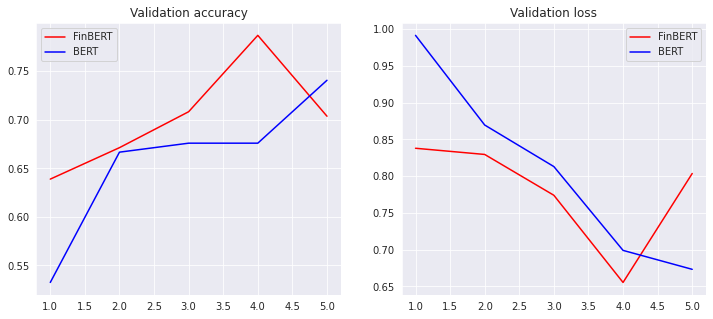

In [ ]:
# here we plot BERT vs finBERT
finbert_train_loss = []
finbert_val_loss = []
finbert_train_acc = []
finbert_val_acc = []
bert_val_loss = [0.9916209578514099, 0.8696171641349792, 0.8130695223808289, 0.6990460753440857, 0.6732652187347412]
bert_acc = [0.5324074074074074, 0.6666666666666666, 0.6759259259259259, 0.6759259259259259, 0.7407407407407407]


for log_history in trainer.state.log_history:

  if 'train_loss' in log_history.keys():
    # Deal with trianing loss.
    finbert_train_loss.append(log_history['train_loss'])
    finbert_train_acc.append(log_history['train_Accuracy'])
    
  elif 'eval_loss' in log_history.keys():
    # Deal with eval loss.
    finbert_val_loss.append(log_history['eval_loss'])
    finbert_val_acc.append(log_history['eval_Accuracy'])

sns.set_style('darkgrid')

x = range(1, len(finbert_train_acc) + 1)
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(x, finbert_val_acc, 'r', label = 'FinBERT')
plt.plot(x, bert_acc, 'b', label = 'BERT')
plt.title('Validation accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(x, finbert_val_loss, 'r', label = 'FinBERT')
plt.plot(x, bert_val_loss, 'b', label = 'BERT')
plt.title('Validation loss')
plt.legend()

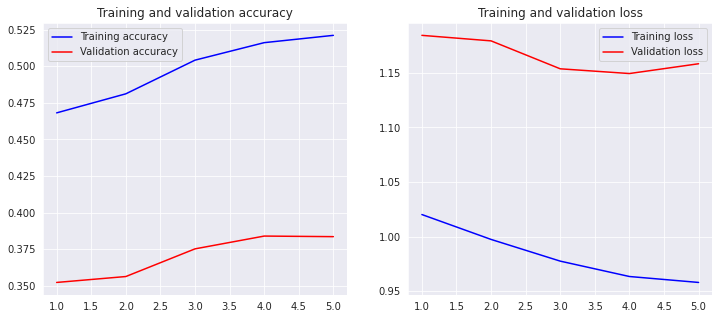

In [ ]:
# here we plot finBERT training
sns.set_style('darkgrid')

finbert_train_loss = []
finbert_val_loss = []
finbert_train_acc = []
finbert_val_acc = []

for log_history in trainer.state.log_history:

  if 'train_loss' in log_history.keys():
    # Deal with trianing loss.
    finbert_train_loss.append(log_history['train_loss'])
    finbert_train_acc.append(log_history['train_Accuracy'])
    
  elif 'eval_loss' in log_history.keys():
    # Deal with eval loss.
    finbert_val_loss.append(log_history['eval_loss'])
    finbert_val_acc.append(log_history['eval_Accuracy'])

x = range(1, len(finbert_train_acc) + 1)
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(x, finbert_train_acc, 'b', label = 'Training accuracy')
plt.plot(x, finbert_val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(x, finbert_train_loss, 'b', label = 'Training loss')
plt.plot(x, finbert_val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
trainer.predict(test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


(array([0.67089431, 0.53011436, 0.60893855]), array([0.53612266, 0.76382278, 0.49958333]), array([0.5959844 , 0.62586259, 0.54886702]), array([3848, 2731, 2400]))


PredictionOutput(predictions=array([[ 1.1897818,  2.740166 , -4.2689333],
       [ 1.0860116,  3.1160717, -4.3964705],
       [-3.1065092,  6.1474695, -2.0017674],
       ...,
       [ 2.2150695, -4.0159945,  0.3592593],
       [ 4.2244544, -3.5040836, -2.2149353],
       [ 0.9382123,  1.1161212, -2.3684924]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 0]), metrics={'test_loss': 2.3114173412323, 'test_Accuracy': 0.5956119835170954, 'test_F1': 0.5924779525451968, 'test_Precision': 0.6115153276933849, 'test_Recall': 0.5956119835170954, 'test_runtime': 172.2495, 'test_samples_per_second': 52.128, 'test_mem_cpu_alloc_delta': 323584, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 0, 'test_mem_gpu_peaked_delta': 359882752})